<a href="https://colab.research.google.com/github/dalexa10/Scientific_Visualization/blob/main/7_Thresdholding_segmentation_classification/CT_Volume_Viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ray Marching

###NOTE:
To run this code, you first need to dowload the .vtk.gz file from [here](https://github.com/dalexa10/Scientific_Visualization/tree/main/7_Thresdholding_segmentation_classification/viz_files) and manually uploaded to Google Colab.
Apparently, there's some issues when trying to pull the file directly from GitHub into the notebook  

In this activity, you will march rays through a VTK render to implement various transfer and composite functions.

The outline of this activity will be:
1. Implementing a grayscale transfer function with the max intensity operator
2. Implementing an alpha transfer function with the over operator
3. Implementing the ray function with the ray casting method.

Starter Code:

In [1]:
!pip install vtk

In [2]:
import random, os, gzip, numpy, vtk
import numpy as np
from vtk.util import numpy_support as VN
from PIL import Image

VTK_FILE = "./HeadCT.vtk"

def compositeKeepA(a,b):
    return a

def getVolumeScalars(volume):
    scalars = VN.vtk_to_numpy(volume.GetPointData().GetArray("scalars"))
    return scalars.reshape(volume.GetDimensions(),order="F")

def volumeRender(displaySlice, volume, transfer, composite, yval=-1):
    # get the dimensions of the volume array
    xsize, ysize, zsize = volume.GetDimensions()
    # get the min and max values of the scalars for volume
    srange              = volume.GetScalarRange()
    # get the scalars themselves
    scalars             = getVolumeScalars(volume)

    # compute the resulted image based on the volume input
    # you will implement this function later
    img = ray((xsize, ysize, zsize), scalars, srange, transfer, composite, yval)

    # write the output image to the displaySlice
    for x in range(xsize):
        for z in range(zsize):
            ra, ga, ba, aa = img[x, z]
            displaySlice.SetScalarComponentFromFloat(x, z, 0, 0, ra*aa)
            displaySlice.SetScalarComponentFromFloat(x, z, 0, 1, ga*aa)
            displaySlice.SetScalarComponentFromFloat(x, z, 0, 2, ba*aa)

def saveSliceToImage(displaySlice,fname):
    xs,zs,_ = displaySlice.GetDimensions()
    scalars = VN.vtk_to_numpy(displaySlice.GetPointData().GetArray(0))
    scalars = (255*scalars).astype(numpy.uint8)
    scalars = scalars.reshape((xs,zs,3),order="F")
    scalars = numpy.rot90(scalars,1)
    im      = Image.fromarray(scalars)
    im.save(fname)
    display(im)

def decompressVtkData(ifname,ofname):
    if not os.path.exists(ofname):
        if os.path.exists(ifname):
            with gzip.GzipFile(ifname, 'rb') as fin:
                with open(ofname, 'wb') as fout:
                    fout.write(fin.read())

# transfer = transfer function to pass to volumeRender()
# composite = composite function to pass to volumeRender()
# ymin = y value to pass to volumeRender
def render(transfer,composite,fname,yval=-1):
    decompressVtkData("/content/" + VTK_FILE+".gz",VTK_FILE)

    reader = vtk.vtkStructuredPointsReader()
    reader.SetFileName(VTK_FILE)
    reader.Update()

    volume = reader.GetOutput()
    xsize, ysize, zsize = volume.GetDimensions()

    displaySlice = vtk.vtkImageData()
    displaySlice.SetExtent(0,xsize-1,0,zsize-1,0,0);
    displaySlice.AllocateScalars(vtk.VTK_FLOAT,3);
    volumeRender(displaySlice,volume,transfer,composite,yval)
    displaySlice.Modified()

    saveSliceToImage(displaySlice,fname)

Note: Run the line below twice (second time after ~ 30 seconds the first attemp). For some reason, Colab fails to load and decompress the file automatically

In [3]:
decompressVtkData(VTK_FILE+".gz",VTK_FILE)

# Part 1: Maximum intensity projection

Implement `transferGrayscale()`:

- function should return an `(r,g,b,a)` tuple
- `r`, `g`, and `b` components should be equal to the linear interpolation of `scalar` between the min and max values in `srange`, normalized to (0,1)
- `a` component should always be 1

In [12]:
def transferGrayscale(scalar, srange):
    # c = np.interp(scalar, srange, [0, 1]).item() # item() converts np.float to python native float variable
    t = (scalar - srange[0]) / (srange[1] - srange[0])
    c = (1 - t) * 0 + t * 1
    a = 1
    return (c, c, c, a)

Test `transferGrayscale()`

In [5]:
# unit tests for transferGrayscale()
r       = [4,7]
scalars = [5,6,5.5,6.5]
grays   = [2/6,4/6,3/6,5/6]
for i in range(len(scalars)):
    numpy.testing.assert_allclose(transferGrayscale(scalars[i],r)[0],grays[i], rtol=1e-2)
    numpy.testing.assert_allclose(transferGrayscale(scalars[i],r)[1],grays[i], rtol=1e-2)
    numpy.testing.assert_allclose(transferGrayscale(scalars[i],r)[2],grays[i], rtol=1e-2)
    numpy.testing.assert_allclose(transferGrayscale(scalars[i],r)[3],1, rtol=1e-2)

**Before we can render the volume into a graph, we still need to provide how the ray interacts with the volume to generate the pixels of the graph.**

Implement ```ray(size, scalars, srange, transfer, composite, yval = -1)```. This function will return the generated pixel values of an image when a ray passess through the volume along the y-axis direction.

The inputs are:
- ```size = (xsize, ysize, zsize)``` are the dimensions of the volume
- ```scalars```, a numpy array of shape ```(xsize, ysize, zsize)``` with the ```scalar``` value at each position
- ```srange = [min, max]``` are the maximum and minimum values of ```scalars```. This will be used in the transfer function
- ```transfer```, the transfer function that returns a pixel value based on the input ```scalar``` value at a position. The ```transferGrayscale()``` function you just implemented is a transfer function
- ```composite```, the composite function. This function takes two pixel values of the form (r, g, b, a) and returns the composed pixel value. The first input should be the composed pixel value from before, and the second should be the new pixel value.
- ```yval```, representing the y value the ray passes through. If ```yval = -1```, the ray will pass through all possible y values in range ```(0, ysize)``` (in the corresponding direction); otherwise, only consider the y value ```yval```

**Return**: A numpy array of shape ```(xsize, zsize, 4)``` representing the pixel value of the image. More specifically, ```output[x, z]``` should be the ```[r, g, b, a]``` values of the pixel in position ```(x, z)```. For computing the pixel value at each position ```(x, z)``` assume that the ray goes through all the pixels with that x and z coordinate but different values for the y coordinate.



In [10]:
import numpy as np
def ray(size, scalars, srange, transfer, composite, yval = -1):
    out_array = np.empty([size[0], size[2], 4], dtype=float)  # Initialize output array

    for i in range(size[0]):
        for k in range(size[2]):
            if yval == -1:
                comp = transfer(scalars[i, 0, k], srange)
                for j in range(size[1] - 1):
                    nxt = transfer(scalars[i, j + 1, k], srange)
                    comp = composite(comp, nxt)
                out_array[i, k, :] = comp
            else:
                comp = transfer(scalars[i, yval, k], srange)
                out_array[i, k, :] = comp
    return out_array

Test `ray()` function

In [7]:
# unit tests for ray()
# make sure your transferGrayscale() is working before running these tests
scalars = np.array([[[1, 2, 3], [2, 3, 4]], [[3, 4, 5], [4, 5, 6]]])
size = scalars.shape
srange = [0, 7]
img = ray(size, scalars, srange, transferGrayscale, compositeKeepA)
numpy.testing.assert_allclose(img[0, 0], np.array([1/7, 1/7, 1/7, 1]))
numpy.testing.assert_allclose(img[1, 1], np.array([4/7, 4/7, 4/7, 1]))
numpy.testing.assert_allclose(img[0, 2], np.array([3/7, 3/7, 3/7, 1]))

Test render using `transferGrayscale()`

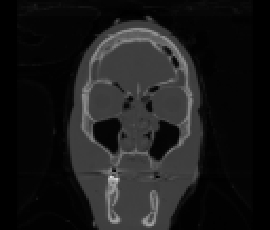

In [8]:
render(transferGrayscale,compositeKeepA,"test.png",200)

Implement `compositeMax()`:

- `a` and `b` are both rgba tuples of the form `(red,green,blue,alpha)`
- return value should be the max of `a` and `b` using standard ordering operators (e.g., compare red, then green, then blue, then alpha)

In [9]:
def compositeMax(a,b):
    if a > b:
        return a
    else:
        return b

Test `compositeMax()`

In [13]:
# unit tests for compositeMax()
for i in range(1000):
    a = tuple([random.random() for _ in range(4)])
    b = tuple([random.random() for _ in range(4)])
    if a > b:
        assert(compositeMax(a,b) == a)
    else:

        assert(compositeMax(a,b) == b)

Test render using `compositeMax()`

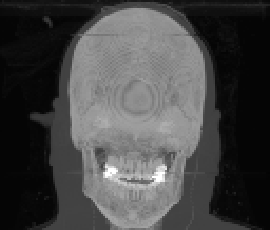

In [14]:
render(transferGrayscale,compositeMax,"part1.png")

# Part 2: "X-ray" projection
Implement `transferAlpha()`:

- function should return an `(r,g,b,a)` tuple
- `r`, `g`, and `b` components should always be 1
- `a` component should be equal to the linear interpolation of `scalar` between the min and max values in `srange`, normalized to (0,1), and multiplied by the constant `0.0125`

In [15]:
def transferAlpha(scalar, srange):
#     a = 0.0125 * np.interp(scalar, srange, [0, 1]).item()

    t = (scalar - srange[0]) / (srange[1] - srange[0])
    a = 0.0125 * ((1 - t) * 0 + t * 1)

    return (1, 1, 1, a)

Test `transferAlpha()`

In [16]:
# unit tests for transferAlpha()
r       = [4,7]
scalars = [5,6,5.5,6.5]
alphas  = [0.004167,0.008333,0.00625,0.010417]
for i in range(len(scalars)):
    numpy.testing.assert_allclose(transferAlpha(scalars[i],r)[0],1, rtol=1e-2)
    numpy.testing.assert_allclose(transferAlpha(scalars[i],r)[1],1, rtol=1e-2)
    numpy.testing.assert_allclose(transferAlpha(scalars[i],r)[2],1, rtol=1e-2)
    numpy.testing.assert_allclose(transferAlpha(scalars[i],r)[3],alphas[i], rtol=1e-2)

Implement `compositeOver()`:

- `a` and `b` are both rgba tuples of the form `(red,green,blue,alpha)`
- return value should be the tuple `(ro,go,bo,ao)`, or the rgba color resulting from the application of the over operator for `a` over `b`
- see image below and  https://en.wikipedia.org/wiki/Alpha_compositing#Description for over operator computation reference

In [17]:
def compositeOver(a,b):
    alfa_0 = a[-1] + b[-1] * (1 - a[-1])
    C_0 = (np.array(a[:-1]) * a[-1] + np.array(b[:-1]) * b[-1] * (1 - a[-1])) / alfa_0
    comp_tuple = tuple(C_0) + (alfa_0, )
    return comp_tuple

Test `compositeOver()`

In [18]:
# unit tests for compositeOver()
a = (0.4,0.7,0.2,0.5)
b = (0.1,0.9,0.8,0.6)
aoverb = compositeOver(a,b)
numpy.testing.assert_allclose(aoverb[0],0.2875, rtol=1e-2)
numpy.testing.assert_allclose(aoverb[1],0.7775, rtol=1e-2)
numpy.testing.assert_allclose(aoverb[2],0.425, rtol=1e-2)
numpy.testing.assert_allclose(aoverb[3],0.8, rtol=1e-2)
bovera = compositeOver(b,a)
numpy.testing.assert_allclose(bovera[0],0.175, rtol=1e-2)
numpy.testing.assert_allclose(bovera[1],0.85, rtol=1e-2)
numpy.testing.assert_allclose(bovera[2],0.65, rtol=1e-2)
numpy.testing.assert_allclose(bovera[3],0.8, rtol=1e-2)

Test render using `transferAlpha()` and `compositeOver()`

<ipython-input-17-521ce6541127>:3: RuntimeWarning: invalid value encountered in true_divide
  C_0 = (np.array(a[:-1]) * a[-1] + np.array(b[:-1]) * b[-1] * (1 - a[-1])) / alfa_0


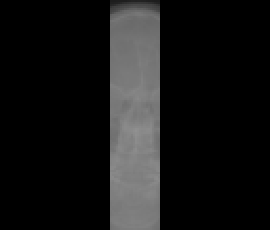

In [20]:
render(transferAlpha,compositeOver,"part2.png", yval = -1)